<a href="https://colab.research.google.com/github/kevincoakley/DT8807/blob/main/iris_tensorflow_from_scratch_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import math

In [2]:
# Load IRIS data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
print(df.head())

     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


In [3]:
# extract first 100 class labels (50 iris-setosa and 50 iris-versicolor)
x = df.iloc[0:100, [0, 2]].values
y = df.iloc[0:100, 4].values

# Set the label Iris-setosa as 0 and Iris-versicolor as 1
y = np.where(y=="Iris-setosa", 0, 1)

# Convert the labels to rank-1 tensors
y = [[i] for i in y]

#print(x) 
#print(y) 

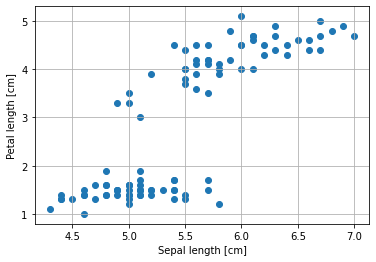

In [4]:
# scatter plot of the data
plt.scatter(x[:, 0], x[:, 1])
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.grid()
plt.show()

In [5]:
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        # Create a matix W with shape (input_size, output_size) with random initial values
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        # Create a vector b with shape (output_size) with initial values of 0
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    # Apply forward pass when called
    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    # Method for returning the current layer weights
    @property
    def weights(self):
        return [self.W, self.b]

In [6]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers
        self.loss = []

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

    def save_loss(self, l):
      self.loss.append(l)


In [7]:
# Create a binary classification model that has 2 inputs (sepal length & petal length) 
# and one output (iris-setosa or iris-versicolor)
model = NaiveSequential([
    NaiveDense(input_size=2, output_size=1, activation=tf.keras.activations.sigmoid)
])

assert len(model.weights) == 2

In [8]:
# Create a BatchGenerator Class to sort the dataset into mini batches
class BatchGenerator:
    def __init__(self, features, labels, batch_size=100):
        assert len(features) == len(labels)
        self.index = 0
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(features) / batch_size)

    def next(self):
        features = self.features[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return features, labels

In [9]:
def one_training_step(model, features_batch, labels_batch):
    with tf.GradientTape() as tape:
        # Run the forward pass and compute the predictions under a GradientTape scope
        predictions = model(features_batch)
        per_sample_losses = tf.keras.losses.binary_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
   
    # Compute the gradient of the loss with reguard to the weights
    gradients = tape.gradient(average_loss, model.weights)
    
    # Updated the weights using the gradients
    update_weights(gradients, model.weights)
    
    return average_loss

In [10]:
learning_rate = .1

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        # assign_sub is the equivalent of -= for TF vars
        w.assign_sub(g * learning_rate)

In [11]:
def fit(model, features, labels, epochs, batch_size=128):

    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(features, labels)
        for batch_counter in range(batch_generator.num_batches):
            features_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, features_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
                model.save_loss(loss.numpy())


Epoch 0
loss at batch 0: 0.67
Epoch 1
loss at batch 0: 0.65
Epoch 2
loss at batch 0: 0.63
Epoch 3
loss at batch 0: 0.60
Epoch 4
loss at batch 0: 0.58
Epoch 5
loss at batch 0: 0.56
Epoch 6
loss at batch 0: 0.54
Epoch 7
loss at batch 0: 0.53
Epoch 8
loss at batch 0: 0.51
Epoch 9
loss at batch 0: 0.49


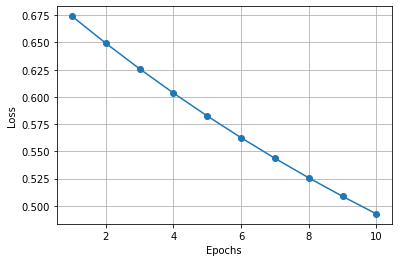

In [12]:
fit(model, tf.dtypes.cast(x, tf.float32), tf.dtypes.cast(y, tf.int64), epochs=10, batch_size=10)

plt.plot(range(1,len(model.loss)+1), model.loss, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [13]:
predictions = model(tf.dtypes.cast(x, tf.float32))

# Round all predictions to 0 or 1
round_predictions = np.array([ [round(i[0])] for i in predictions.numpy() ])

# Calculate the error rate
error = 0
for index, pred in enumerate(round_predictions):
  if round(pred[0]) != y[index][0]:
    error += 1

print("error: ", error/len(y))

error:  0.0


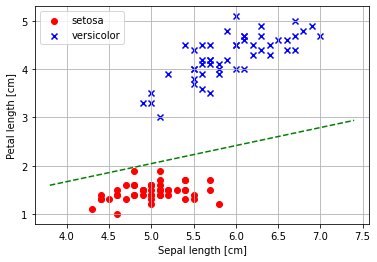

In [16]:
# scatter plot of predictions
plt.scatter(x[round_predictions.flatten()==0, 0], x[round_predictions.flatten()==0, 1], color='red', marker='o', label='setosa')
plt.scatter(x[round_predictions.flatten()==1, 0], x[round_predictions.flatten()==1, 1], color='blue', marker='x', label='versicolor')

# Get the weights and the bias from the model
W, b = model.weights
W = W.numpy()
b = b.numpy()

# decsion line
xx1 = np.arange(x[:,0].min() - .5, x[:,0].max() + .5, 0.1)
# line equation: W[0] * x + W[1] * y + b; solve for y = -W[0]/W[1] * x - b/W[1]
xx2 = -W[0]/W[1] * xx1 - b/W[1]
plt.plot(xx1, xx2, 'g--')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.grid()
plt.show()